# Step 1 :Import Dataset
In the code cell below, we import a dataset of actress images. We populate a few variables through the use of the load_files function from the scikit-learn library:

1. train_files, valid_files, test_files - numpy arrays containing file paths to images
2. train_targets, valid_targets, test_targets - numpy arrays containing onehot-encoded classification labels
3. actress_names - list of string-valued dog breed names for translating labels

In [34]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 5)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../Celebs/train')
valid_files, valid_targets = load_dataset('../Celebs/valid')
test_files, test_targets = load_dataset('../Celebs/test')

# load list of actress names
actress_names = [item.split("/")[-2] for item in sorted(glob("../Celebs/train/*/"))]

#train_files -> paths to the files like dogImages/train/095.Kuvasz/Kuvasz_06442.jpg
#train_targets -> 2d array of size*133 categorical all 0s one 1 based on which category the file belongs

# print statistics about the dataset
# print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print(train_files[240])
print('There are %d training actress images.' % len(train_files))
print('There are %d validation actress images.' % len(valid_files))
print('There are %d test actress images.'% len(test_files))

print(actress_names)

There are 4970 total dog images.

../Celebs/train/priyanka/752.jpg
There are 3978 training actress images.
There are 496 validation actress images.
There are 496 test actress images.
['anushka', 'deepika', 'jaq', 'kat', 'priyanka']


# Pre-process the data
Here we are using tensorflow as backend for keras and it requires our images as a certain 4D array a.k.a 4D Tensor with shape.

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where nb_samples corresponds to the total number of images (or samples), and rows, columns, and channels correspond to the number of rows, columns, and channels for each image, respectively.

The path_to_tensor takes a string spacifying file location and it does the following operation.

1. Resizes the image as (224,224).
2. Convert the squared image as an array (3d array)
3. Expand the 3d array to 4d array as (1,224,224,3)

Another helper function paths_to_tensor takes an array of image file locations as param and in turn calls path_to_tensor on all of them and then vertically stack the output.

Here, nb_samples is the number of samples, or number of images, in the supplied array of image paths. It is best to think of nb_samples as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [2]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [3]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 496/496 [00:04<00:00, 101.68it/s]


# TODO
1. Create a CNN from scratch with these tensors
2. Create Augmentations and with use of that, And create bottleneck features and save it to S3
3. Fetch bottleneck features from S3 and use transfer learning to build a CNN

# Step 2 Create CNN from the scratch
Here we will create a CNN from the scratch using Keras. Note that we will not be using any models (vgg,resnet) we will take images as input and train our model.

Our target here is to create simplistic model with training,test accuracy above 5%.

Be careful with adding too many trainable layers! More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process. Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train.


In [4]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

### TODO: Define your architecture.
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(GlobalAveragePooling2D())
# model.add(Flatten())
model.add(Dense(train_targets.shape[1], activation='softmax'))
model.add(Dropout(0.4))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### Compile the Model

In [5]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the model

In [6]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 50

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 3978 samples, validate on 496 samples
Epoch 1/50
3978/3978 [==============================] - 17s 4ms/step - loss: 7.1750 - acc: 0.2293 - val_loss: 1.6070 - val_acc: 0.3085

Epoch 00001: val_loss improved from inf to 1.60702, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/50
3978/3978 [==============================] - 11s 3ms/step - loss: 7.3807 - acc: 0.2594 - val_loss: 1.5842 - val_acc: 0.3085

Epoch 00002: val_loss improved from 1.60702 to 1.58423, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 3/50
3978/3978 [==============================] - 11s 3ms/step - loss: 7.1612 - acc: 0.2647 - val_loss: 1.5667 - val_acc: 0.3085

Epoch 00003: val_loss improved from 1.58423 to 1.56673, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 4/50
3978/3978 [==============================] - 11s 3ms/step - loss: 6.9376 - acc: 0.2715 - val_loss: 1.5664 - val_acc: 0.3085

Epoch 00004: val_loss improved from 1.56673 to 1.56638, saving mo

### Load the Modelwith best validation loss

In [7]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the model
Try out the model on test data

In [8]:
actress_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

test_accuracy = 100*np.sum(np.array(actress_predictions)==np.argmax(test_targets, axis=1))/len(actress_predictions)

print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 35.0806%


### Create bottleneck features from Augmented Data
As we have very less number of samples, We will augment the data and compute bottleneck features for xception model.

We will save it and then later use it for training the model.

In [4]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import keras.applications.xception as xception

import numpy as np
from tqdm import tqdm, trange
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

#load the model
# model = xception.Xception(weights='imagenet', include_top=False)
xception_image_size = (224,224)
batch_size = 20

# This is the augmentation configuration.
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    horizontal_flip=True)

train_generator = datagen.flow_from_directory(
                '../Celebs/train',
                target_size=xception_image_size,
                batch_size=batch_size)

valid_generator = datagen.flow_from_directory(
                '../Celebs/valid',
                target_size=xception_image_size,
                batch_size=batch_size)

Found 3978 images belonging to 5 classes.
Found 496 images belonging to 5 classes.


In [6]:
def getFeaturesForAugmentedData(generator, n_iterations):
    
    list_of_features=[]
    list_of_targets=[]
    for i in trange(n_iterations):
        x,y = generator.next()
        # preprocess and compute bottleneck features
        f = model.predict(xception.preprocess_input(x))
        # append features and labels to lists
        list_of_features.append(f)
        list_of_targets.append(y)
            
    # return features and targets as numpy arrays
    return np.vstack(list_of_features),np.vstack(list_of_targets)

In [7]:
train_x, train_y = getFeaturesForAugmentedData(train_generator, 5000//batch_size)
valid_x, valid_y = getFeaturesForAugmentedData(valid_generator, 500//batch_size)

100%|██████████| 25/25 [00:24<00:00,  1.00it/s]


### Loading test files as it is, Not using generator

In [8]:
def path_to_Xception_feature(img_path):
    img = image.load_img(img_path, target_size=xception_image_size)
    tensor = xception.preprocess_input(np.expand_dims(image.img_to_array(img), axis=0))
    return model.predict(tensor)

def paths_to_Xception_features(img_paths):
    list_of_features = [path_to_Xception_feature(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_features)

test_x = paths_to_Xception_features(test_files)
test_y = test_targets

100%|██████████| 496/496 [00:21<00:00, 23.07it/s]


In [6]:
# Save train and test features for further use
np.savez('ActressAugmentedData.npz',train_x=train_x, train_y=train_y,\
         valid_x=valid_x, valid_y=valid_y, test_x=test_x, test_y=test_y)

In [7]:
#Load the data 
fh = np.load('ActressAugmentedData.npz')
train_Xception, train_targets = fh['train_x'], fh['train_y']
valid_Xception, valid_targets = fh['valid_x'], fh['valid_y']
test_Xception, test_targets = fh['test_x'], fh['test_y']

KeyboardInterrupt: 

### Create a model on top of this and summarize

In [17]:
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout, Dense
from keras.models import Sequential

Xception_model = Sequential()
Xception_model.add(GlobalAveragePooling2D(input_shape=train_x.shape[1:]))
Xception_model.add(Dropout(0.4))
Xception_model.add(Dense(512, activation='relu'))
Xception_model.add(Dropout(0.4)) #Dropout between input and hidden
Xception_model.add(Dense(5, activation='softmax'))


Xception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 2565      
Total params: 1,051,653
Trainable params: 1,051,653
Non-trainable params: 0
_________________________________________________________________


### Compile the model

In [18]:
Xception_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model
Train your model in the code cell below. Use model checkpointing to save the model that attains the best validation loss.

In [19]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=0, save_best_only=True)

Xception_model.fit(train_x, train_y,
                   validation_data=(valid_x, valid_y),
                   epochs=50, batch_size=batch_size, callbacks=[checkpointer], verbose=2)

Train on 4998 samples, validate on 496 samples
Epoch 1/50
 - 4s - loss: 1.5011 - acc: 0.3603 - val_loss: 1.4188 - val_acc: 0.3871
Epoch 2/50
 - 3s - loss: 1.3692 - acc: 0.4242 - val_loss: 1.4318 - val_acc: 0.3710
Epoch 3/50
 - 3s - loss: 1.3163 - acc: 0.4600 - val_loss: 1.3790 - val_acc: 0.4274
Epoch 4/50
 - 3s - loss: 1.2500 - acc: 0.4854 - val_loss: 1.3696 - val_acc: 0.4496
Epoch 5/50
 - 3s - loss: 1.2115 - acc: 0.5104 - val_loss: 1.3671 - val_acc: 0.4073
Epoch 6/50
 - 3s - loss: 1.1627 - acc: 0.5350 - val_loss: 1.3762 - val_acc: 0.4234
Epoch 7/50
 - 3s - loss: 1.1171 - acc: 0.5606 - val_loss: 1.4107 - val_acc: 0.4073
Epoch 8/50
 - 3s - loss: 1.0987 - acc: 0.5590 - val_loss: 1.3818 - val_acc: 0.4496
Epoch 9/50
 - 3s - loss: 1.0362 - acc: 0.5808 - val_loss: 1.3533 - val_acc: 0.4254
Epoch 10/50
 - 3s - loss: 1.0148 - acc: 0.6004 - val_loss: 1.3209 - val_acc: 0.4395
Epoch 11/50
 - 3s - loss: 0.9612 - acc: 0.6269 - val_loss: 1.3395 - val_acc: 0.4819
Epoch 12/50
 - 3s - loss: 0.8963 - acc

In [20]:
Xception_model.load_weights('saved_models/weights.best.Xception.hdf5')
Xception_predictions = [np.argmax(Xception_model.predict(
    np.expand_dims(feature, axis=0))) for feature in test_x]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Xception_predictions)==
                           np.argmax(test_y, axis=1))/len(Xception_predictions)
print('Xception model test accuracy: %.4f%%' % test_accuracy)

Xception model test accuracy: 50.8065%


### Let's fine tune the model
From above we see that because our dataset is small and it has less overlapping with Imagenet dataset, We suffer from overfitting. 

Our training accuracy shoots up but validation and test accuracy is not going up. 

So, now we will load resnet model , chop off last convolutional layers , add our conv layers and then train it.

In [9]:
import keras.applications.vgg19 as vgg19 #preprocess_input
image_size = 224
VGG19_model = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

for layer in VGG19_model.layers[:-3]:
    layer.trainable=False

for layer in VGG19_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fc4c0167a20> False
<keras.layers.convolutional.Conv2D object at 0x7fc4c0167978> False
<keras.layers.convolutional.Conv2D object at 0x7fc4e5b6a780> False
<keras.layers.pooling.MaxPooling2D object at 0x7fc4e5b56c88> False
<keras.layers.convolutional.Conv2D object at 0x7fc4e5b4c208> False
<keras.layers.convolutional.Conv2D object at 0x7fc4e5b4c128> False
<keras.layers.pooling.MaxPooling2D object at 0x7fc4e5baba58> False
<keras.layers.convolutional.Conv2D object at 0x7fc4f4690f98> False
<keras.layers.convolutional.Conv2D object at 0x7fc4e5b9a6a0> False
<keras.layers.convolutional.Conv2D object at 0x7fc4e5fef860> False
<keras.layers.convolutional.Conv2D object at 0x7fc4e5fe6fd0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fc4b2f12198> False
<keras.layers.convolutional.Conv2D object at 0x7fc4b2ec0630> False
<keras.layers.convolutional.Conv2D object at 0x7fc4b2ec05c0> False
<keras.layers.convolutional.Conv2D object at 0x7fc4b2eeb780>

In [14]:
from keras import models
from keras import layers
new_model = models.Sequential()
new_model.add(VGG19_model)

# BEFORE ADDING NEW LAYERS WE WILL COMPUTE BOTTLENECK FEATURES FOR THIS TWISTED (WITHOUT LAST 2 LAYER) NETWORK.
# And add the stuff ,new layers and all and train it.

new_model.add(layers.GlobalAveragePooling2D())
new_model.add(layers.Dense(1024, activation='relu'))
new_model.add(layers.Dropout(0.5))
new_model.add(layers.Dense(5, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 5125      
Total params: 20,554,821
Trainable params: 5,250,053
Non-trainable params: 15,304,768
_________________________________________________________________


In [11]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
train_batchsize = 100
val_batchsize = 10
 
train_generator = train_datagen.flow_from_directory(
        '../Celebs/train',
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        '../Celebs/valid',
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 3978 images belonging to 5 classes.
Found 496 images belonging to 5 classes.


In [15]:
new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.vgg19_3_1024.hdf5', 
                               verbose=0, save_best_only=True)

new_model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=25,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      callbacks=[checkpointer],verbose=1)

Epoch 1/25
40/39 [==============================] - 107s 3s/step - loss: 13.1620 - acc: 0.1652 - val_loss: 13.4859 - val_acc: 0.1633
Epoch 2/25
26/39 [==================>...........] - ETA: 28s - loss: 13.4774 - acc: 0.1638

KeyboardInterrupt: 

In [16]:
def path_to_VGG19_feature(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    tensor = np.expand_dims(image.img_to_array(img), axis=0)
    return tensor

def paths_to_VGG19_features(image_paths):
    list_of_features = [path_to_VGG19_feature(image_path) for image_path in image_paths]
    return np.vstack(list_of_features)

test_x = paths_to_VGG19_features(test_files).astype('float32')/255
test_y = test_targets

print(test_x.shape)
print(test_y.shape)

(496, 224, 224, 3)
(496, 5)


In [17]:
new_model.load_weights('saved_models/weights.best.vgg19_2.hdf5')
print("WEIGHTS LOADED")
VGG19_predictions = [np.argmax(new_model.predict(np.expand_dims(feature, axis=0))) for feature in test_x]
#Keras expects the input tensor to be in (1,224,224,3). 
#VGG19_predictions will be an array with indexes , we will compare both indexes in next line

test_accuracy = 100*np.sum(np.array(VGG19_predictions) == np.argmax(test_y, axis=1))/len(VGG19_predictions)
#test_y will be like (0,0,1,0,0) take out the max, Or you can compare its element to 1 and get index as well.

print('Test accuracy: %.4f%%' % test_accuracy)

WEIGHTS LOADED
Test accuracy: 66.1290%


In [39]:
def predict_actress_name(img_path):
    tensor = path_to_VGG19_feature(img_path)
    tensor = tensor.astype("float32")/255
    predicted_vector = new_model.predict(tensor)
    print("You Look like {}".format(actress_names[np.argmax(predicted_vector)])) 

You Look like deepika


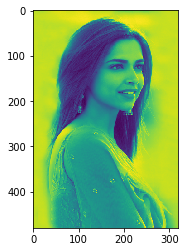

You Look like kat


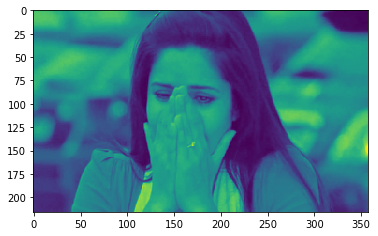

You Look like priyanka


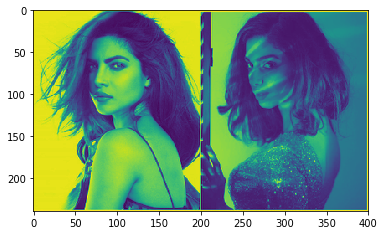

In [42]:
import cv2
import matplotlib.pyplot as plt

def actress_getter(images):
    for image in images:
        predict_actress_name(image)
        img = cv2.imread(image,cv2.COLOR_BAYER_BG2RGB)
        plt.figure()
        plt.imshow(img)
        plt.show()

test_paths = ["../Celebs/train/deepika/836.jpg",
             "../Celebs/train/kat/875.jpg", "../Celebs/train/priyanka/752.jpg"]

actress_getter(test_paths)